In [2]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import csv
import yaml
import random
import re

In [3]:
# Load the processed data
adata = sc.read_h5ad("/Users/aumchampaneri/Databases/Triple/Hs_Nor-CKD-AKF_scRNA_processed.h5ad")

In [4]:
# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

# Change the name of some entries in gene_dict_names to fix plotting errors
gene_dict_names = [re.sub(r'\bC2\b', 'C2_ENSG00000166278', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC3\b', 'C3_ENSG00000125730', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC6\b', 'C6_ENSG00000039537', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC7\b', 'C7_ENSG00000112936', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC9\b', 'C9_ENSG00000113600', name) for name in gene_dict_names]

# Load the tissue type dictionary from the yaml file
with open("Tissue Type Dictionary.yaml", "r") as file:
    cell_type_group = yaml.safe_load(file)

# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_group.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

In [17]:
adata

AnnData object with n_obs × n_vars = 225151 × 29893
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'cell_type_group'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition

In [13]:
# print the gene dictionary
for key, value in gene_dict.items():
    print(f"{key}: {value}")

APOE: ENSG00000130203
ATG5: ENSG00000057663
ATG7: ENSG00000197548
BECN1: ENSG00000126581
C1QA: ENSG00000173372
C1QB: ENSG00000173369
C1QC: ENSG00000159189
C1QTNF6: ENSG00000133466
C1S: ENSG00000182326
C2: ENSG00000166278
C3: ENSG00000125730
C3AR1: ENSG00000171860
C5: ENSG00000106804
C5AR1: ENSG00000197405
C5AR2: ENSG00000134830
C6: ENSG00000039537
C7: ENSG00000112936
C8A: ENSG00000157131
C8B: ENSG00000021852
C8G: ENSG00000176919
C9: ENSG00000113600
CASP1: ENSG00000137752
CASP8: ENSG00000064012
CD46: ENSG00000117335
CD55: ENSG00000196352
CD59: ENSG00000085063
CFD: ENSG00000197766
CFH: ENSG00000000971
CFHR1: ENSG00000244414
CFHR3: ENSG00000116785
CFHR4: ENSG00000134365
CFHR5: ENSG00000134389
CFI: ENSG00000205403
CLU: ENSG00000120885
CR1: ENSG00000203710
CR2: ENSG00000117322
CTSD: ENSG00000117984
CTSS: ENSG00000163131
DDB1: ENSG00000167986
FCN1: ENSG00000085265
FCN2: ENSG00000160339
FCN3: ENSG00000142748
GABARAP: ENSG00000170296
GPNMB: ENSG00000136235
HSP90AA1: ENSG00000080824
IRF3: ENSG0

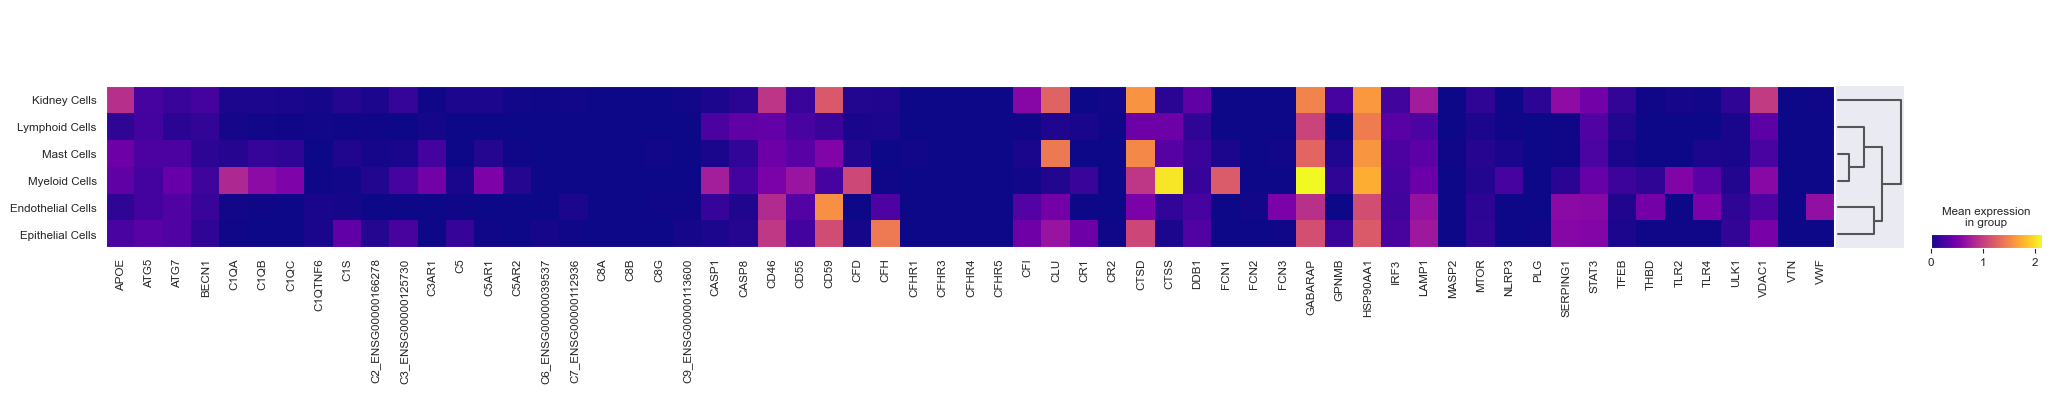

In [32]:
sc.pl.MatrixPlot(adata,
                 gene_dict_names,
                 groupby='cell_type_group',
                 gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Complement Genes Expression in Kidney Cells',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()

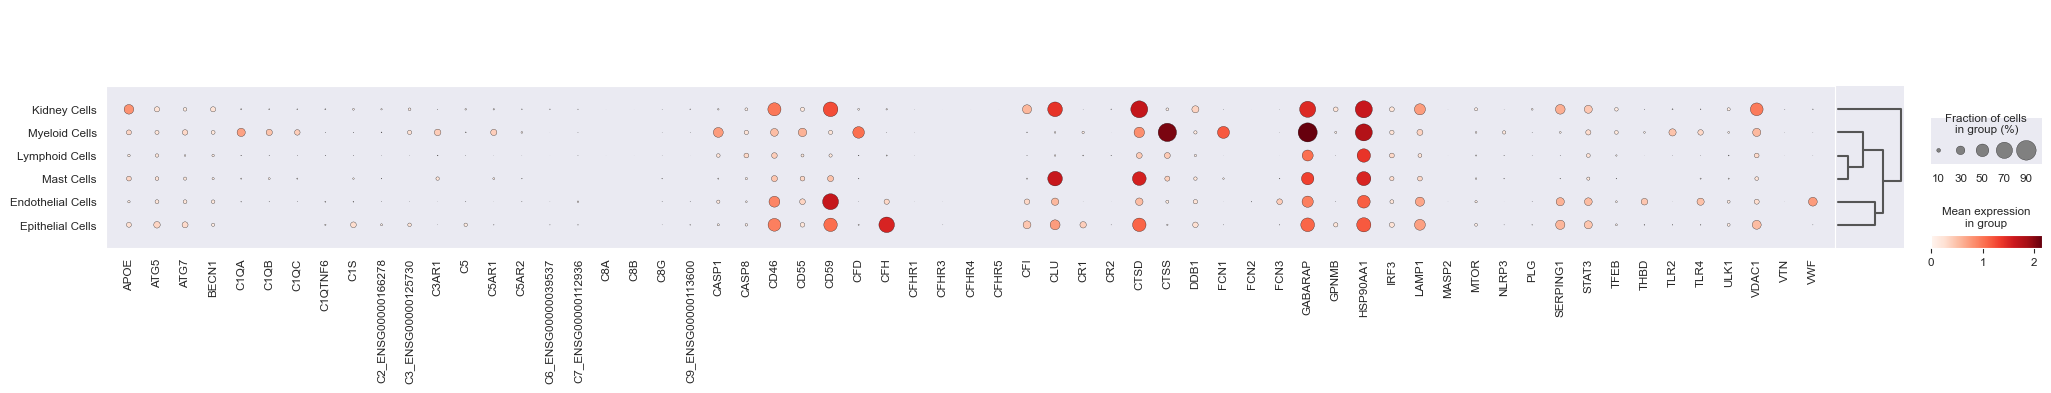

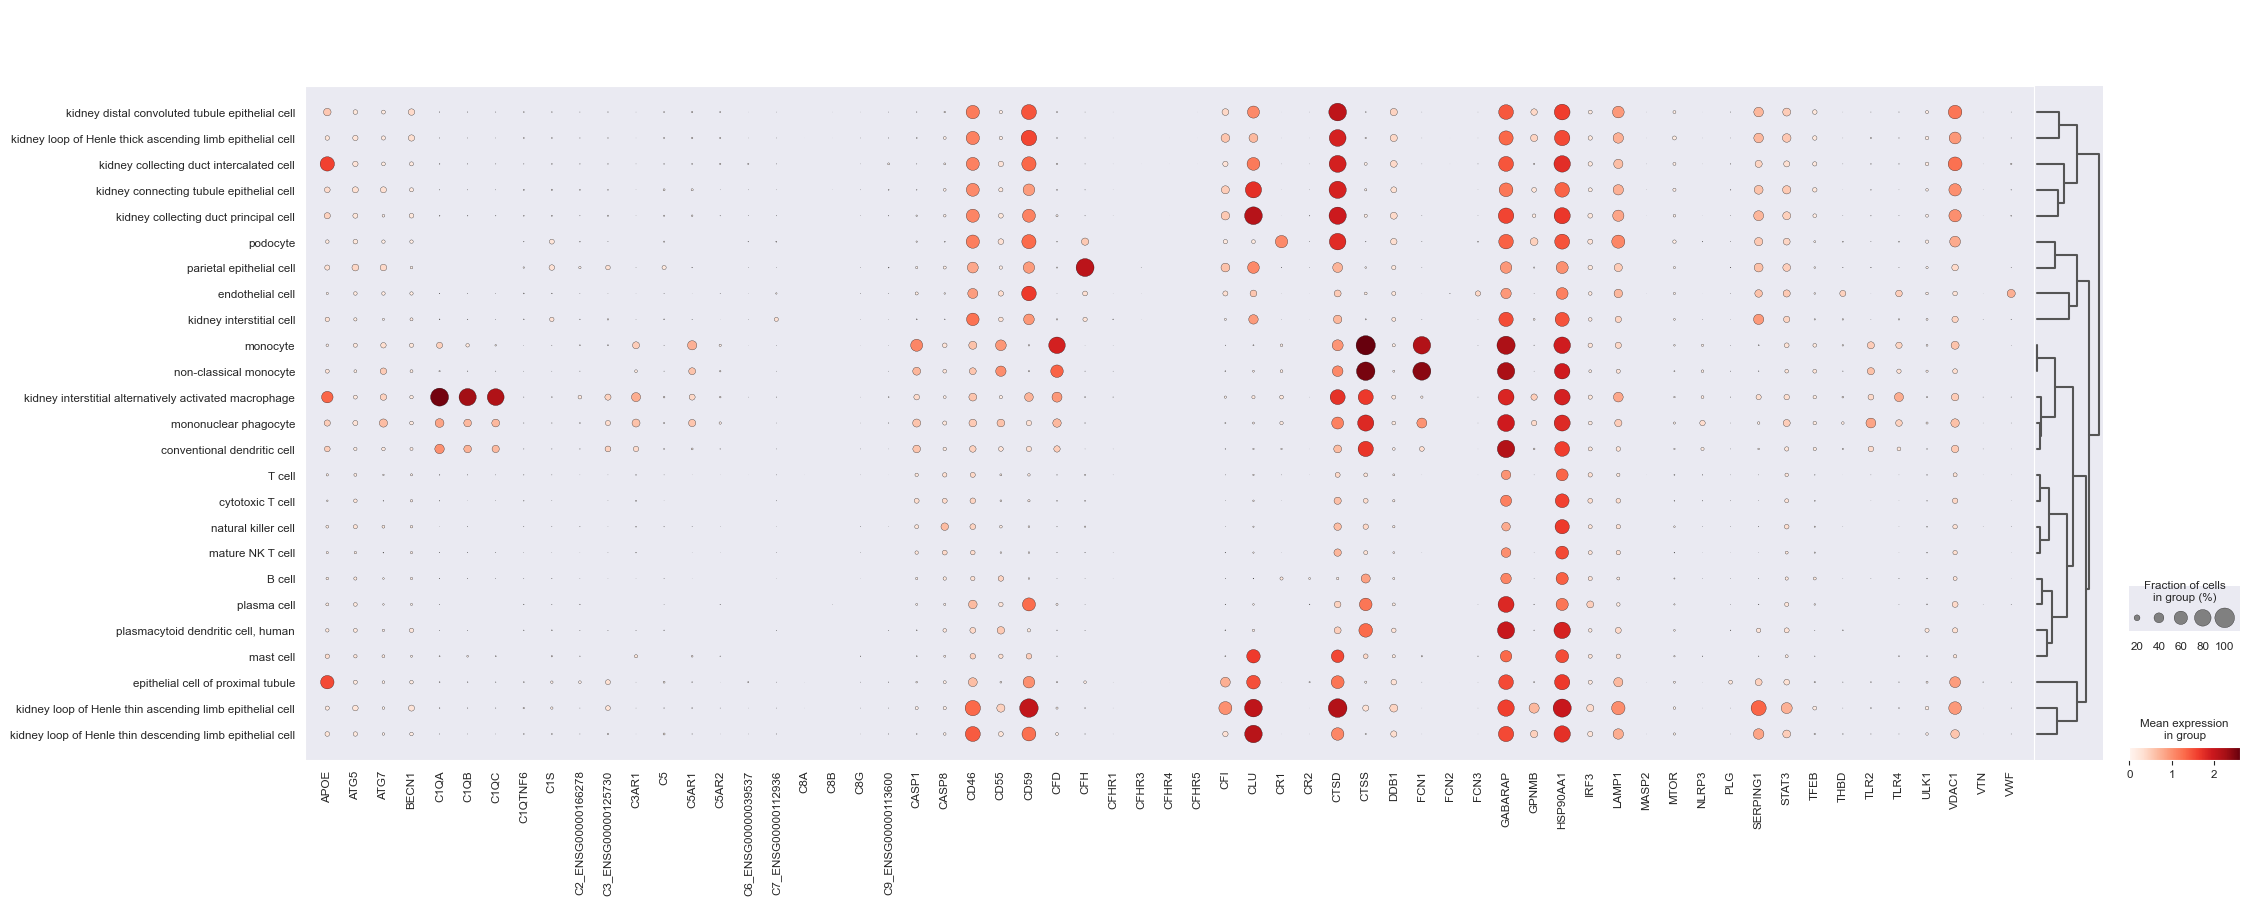

In [6]:
# Subset data based on disease type
disease = 'CKD' # Choose the disease you want to plot (AKI, CKD, Reference)
adata = adata[adata.obs['diseasetype'] == disease, :].copy()

# Change the groupby variable to the one you want to plot
subset = 'cell_type_group' # Choose the groupby variable you want to plot (cell_type, cell_type_group)

# change the gene list to the one you want to plot
gene_list_f = 'gene_dict_names' # Change this to match the gene list you are plotting for the filename
gene_list = gene_dict_names


sc.pl.DotPlot(adata,
              gene_list,
              groupby=f'{subset}',
              gene_symbols='feature_name',
              use_raw=False,
              log=False,
              ).add_dendrogram(show=True,size=0.9).show()

# Change the groupby variable to the one you want to plot
subset = 'cell_type' # Choose the groupby variable you want to plot (cell_type, cell_type_group)

sc.pl.DotPlot(adata,
              gene_list,
              groupby=f'{subset}',
              gene_symbols='feature_name',
              use_raw=False,
              log=False,
              ).add_dendrogram(show=True,size=0.9).show()